# Project 4: Vortex Panel Method

#### Author: Jack Comey

##### Student ID: 915323775
##### Due Date: 11:59 PM Monday 16 NOV 2020

## 0 | Introduction

The **vortex panel method** is a commonly used potential flow analysis designed to model lift using the Kutta-Joukowski lift theorem. As with the source panel method, a geometry is defined as a series of vortex panels. This allows for the lift of a geometry to be easily modelled, as, according the Kutta-Joukowski theorem, lift is a function of circulation.

In this project, a vortex panel method was provided as a part of the problem statement. It was copied into a seperate file, and accessed as an import. The primary purpose of this project is not only to show that the vortex panel method is a valid way to calculate lift by comparison to XFOIL results, but also to show its limitations.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 13 16:15:17 2020

@author: jack
"""

# Imports 

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import copy
import VortexPanelMethod as vpm
import pandas as pd
import pyxfoil as pyx
plt.style.use("seaborn-bright")
%matplotlib inline

params={#FONT SIZES
    'axes.labelsize':30,#Axis Labels
    'axes.titlesize':30,#Title
    'font.size':28,#Textbox
    'xtick.labelsize':22,#Axis tick labels
    'ytick.labelsize':22,#Axis tick labels
    'legend.fontsize':24,#Legend font size
    'font.family':'serif',
    'font.fantasy':'xkcd',
    'font.sans-serif':'Helvetica',
    'font.monospace':'Courier',
    #AXIS PROPERTIES
    'axes.titlepad':2*6.0,#title spacing from axis
    'axes.grid':True,#grid on plot
    'figure.figsize':(12,12),#square plots
    'savefig.bbox':'tight',#reduce whitespace in saved figures#LEGEND PROPERTIES
    'legend.framealpha':0.5,
    'legend.fancybox':True,
    'legend.frameon':True,
    'legend.numpoints':1,
    'legend.scatterpoints':1,
    'legend.borderpad':0.1,
    'legend.borderaxespad':0.1,
    'legend.handletextpad':0.2,
    'legend.handlelength':1.0,
    'legend.labelspacing':0,}
mpl.rcParams.update(params)


#%###########################

# Objects

#%###########################

# Functions


def NACAThicknessEquationMOD(N, A, CA, num_points, *, use_other_x_points=0):
    """
    Generates a non-dimensionalized NACA airfoil given NACA numbers.

    Parameters
    ----------
    N : Ratio of max camber to chord length
    A : Location of max camber
    CA : Thickness ratio 
    num_points : Number of points for airfoil


    Returns
    -------
    x_non_dim_full : List of non-dimenionalized points from 0 to 1 to 0
    z : Airfoil non-dimensionalized z poisition from xc = 0 to 1 to 0
    zcc : Chord line

    """
    p = 0.1 * A
    m = 0.01 * N
    t = 0.01 * CA
    if use_other_x_points is not 0:
        x_non_dim = use_other_x_points
    else:
        x_non_dim = np.linspace(0, 1, num_points)
    
    ztc = x_non_dim*0
    
    # Find thickness relative to camber
    ztc += 0.2969 * (x_non_dim**0.5)
    ztc -= 0.1260 * (x_non_dim**1)
    ztc -= 0.3516 * (x_non_dim**2)
    ztc += 0.2843 * (x_non_dim**3)
    ztc -= 0.1015 * (x_non_dim**4)
    
    ztc *= t/0.2
    
    
    # Find camber line
    zcc = 0*x_non_dim
    try:
        for i in zip(*np.where(x_non_dim <= p)):
            zcc[i] = 2*p*x_non_dim[i]
            zcc[i] -= x_non_dim[i]**2
            zcc[i] *= m * p**-2
    
        for i in zip(*np.where(x_non_dim > p)):
            zcc[i] = 1 - 2*p
            zcc[i] += 2*p*x_non_dim[i]
            zcc[i] -= x_non_dim[i]**2
            zcc[i] *= m * (1-p)**-2

    except:
        zcc = 0*x_non_dim


    # Sum the two
    zup = zcc + ztc
    zdown = zcc - ztc
    
    x_non_dim = np.concatenate((np.flip(x_non_dim), x_non_dim[1:]))
    z = np.concatenate((np.flip(zup), zdown[1:]))
    return x_non_dim, z

def plothusly(ax, x, y, *, xtitle='', ytitle='',
              datalabel='', title='', linestyle='-',
              marker=''):
    """
    A little function to make graphing less of a pain.
    Creates a plot with titles and axis labels.
    Adds a new line to a blank figure and labels it.

    Parameters
    ----------
    ax : The graph object
    x : X axis data
    y : Y axis data
    xtitle : Optional x axis data title. The default is ''.
    ytitle : Optional y axis data title. The default is ''.
    datalabel : Optional label for data. The default is ''.
    title : Graph Title. The default is ''.

    Returns
    -------
    out : Resultant graph.

    """

    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.set_title(title)
    out = ax.plot(x, y, zorder=1, label=datalabel, linestyle = linestyle,
                  marker = marker)
    plt.grid(True)
    plt.legend(loc='best')
    return out


def plothus(ax, x, y, *, datalabel='', linestyle = '-',
            marker = ''):
    """
    A little function to make graphing less of a pain

    Adds a new line to a blank figure and labels it
    """
    out = ax.plot(x, y, zorder=1, label=datalabel, linestyle = linestyle,
                  marker = marker)
    plt.legend(loc='best')

    return out

def deg2rad(deg):
    return deg * np.pi / 180

def rad2deg(rad):
    return rad * 180 / np.pi



## 1 | Vortex Panel Method

Using the code provided on Canvas, solve for flow over a NACA 0012 and Selig 1223 for $\alpha = 0, 8$ degrees. Compare flow differences between the angle of attack and geometry.

### 1.1 | Approach 

The code provided on Canvas is copy-pasted into a seperate .py file, and imported as a module, and named ```vpm```.  The first step is to create the airfoil geometry from which the panels will be based around. The Selig 1223 is imported from a .dat file, and the NACA airfoil is generated from a previously made NACA airfoil function used in **Project 1**. 

In a loop for every angle of attack, the airfoil geometry is generated using the ```vpm.MakePanels()```function, and then panel properties are solved for using the ```vpm.SolveVorticity()``` function. The fluid flow can then be plotted using ```plt.streamplot()```, and the airfoil geometry is plotted on the same plot.

This process is repeated for both airfoil geometries.

### 1.2 | Equations

No equations were required for this section, as the code required for the vortex panel method was already given. The vortex panel method, is, however, very similar to the source panel method covered in the previous project.

### 1.3 | Code and Results

Airfoil geometry is first created/read and then stored. Freestream properties are also generated and stored. The number of panels is labelled, as well as the panel at which the Kutta-Joukowski theorem is enforced, and the index for that panel:

In [2]:
nacaX, nacaZ = NACAThicknessEquationMOD(0, 0, 12, 40)
nacaX, nacaZ = np.flip(nacaX), np.flip(nacaZ)

seligX, seligZ = vpm.ReadXfoilGeometry("AirfoilData/s1223.dat")

# Create Freestream Properties

V_fs = 1.5  # m-s**-1
rho = 1.2  # kg-m**-3
alphalist = deg2rad(np.array([0, 8]))
num_panels = 60

panel_enforced_index = 30  # ndim
missing_panel_index = panel_enforced_index - 1

The main loop is then called for the Selig Airfoil. It iterates over each $\alpha$ value, and solves for the whole airfoil:

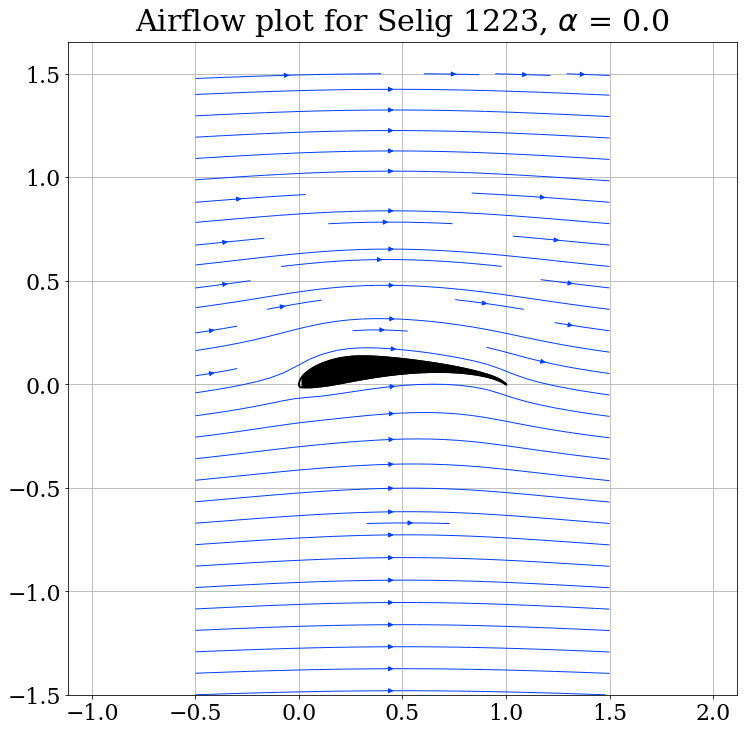

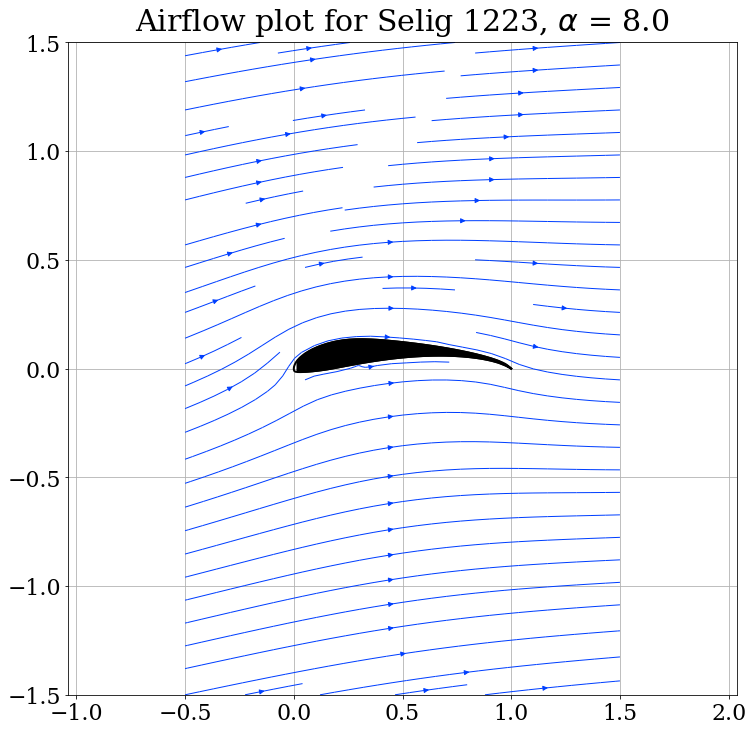

In [3]:
xdat, ydat = seligX, seligZ
airfoilname = "Selig 1223"
for alpha in alphalist:
    
    panel_list = vpm.MakePanels(xdat, ydat, num_panels, 'constant')
    panel_list = vpm.SolveVorticity(panel_list, missing_panel_index,
                                    V_fs, alpha)

    x = np.linspace(-0.5, 1.5, 50)
    y = np.linspace(-1.5, 1.5, 50)
    X, Y = np.meshgrid(x, y)
    u, v = vpm.GetVelocity(X, Y, panel_list, V_fs, alpha)
    V = (u**2 + v**2)**0.5
    fig, flowplot = plt.subplots()
    plt.streamplot(X, Y, u, v, density=1, linewidth=1)
    plt.axis('equal')
    plt.plot(xdat, ydat, color='k', linewidth=2)
    plt.title(fr"Airflow plot for {airfoilname}, $\alpha$ = {rad2deg(alpha)}")
    plt.fill([panel.xc for panel in panel_list],
         [panel.yc for panel in panel_list],
         color='black',
         linestyle='-',
         linewidth=2,
         zorder=2)

Observe that the streamlines follow the geometry on the airfoil for both angles of attack, but to a greater degree at the larger angle of attack. This is not an observation of the proximity of the streamlines to the airfoil, as that is a function of the meshgrid resolution, but rather as a function of the angle of attack.


The same loop is repeated for the NACA 0012 geometry:

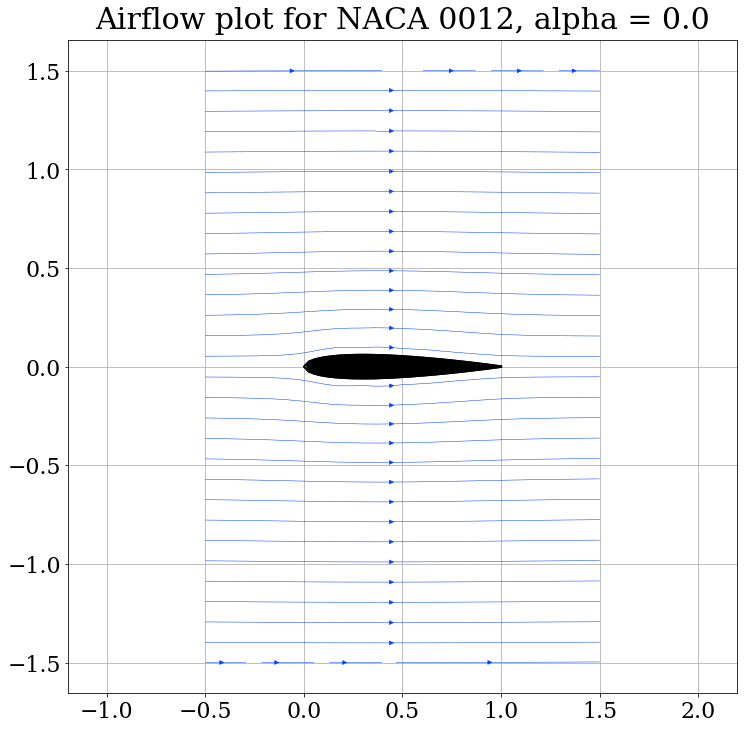

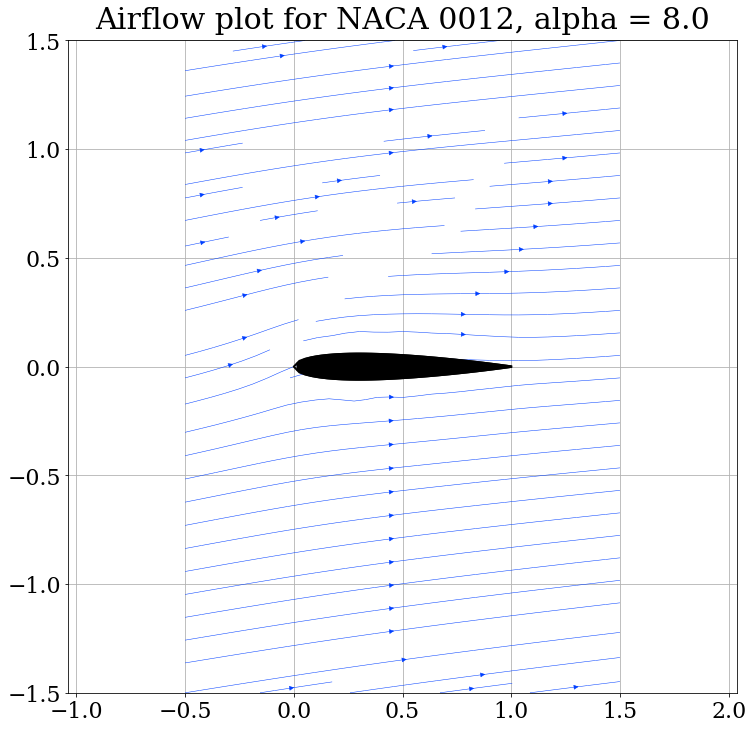

In [4]:
xdat, ydat = nacaX, nacaZ
airfoilname = "NACA 0012"
for alpha in alphalist:
    
    panel_list = vpm.MakePanels(xdat, ydat, num_panels, 'constant')    
    panel_list = vpm.SolveVorticity(panel_list, missing_panel_index,
                                    V_fs, alpha)

    x = np.linspace(-0.5, 1.5, 20)
    y = np.linspace(-1.5, 1.5, 20)
    X, Y = np.meshgrid(x, y)
    u, v = vpm.GetVelocity(X, Y, panel_list, V_fs, alpha)
    V = (u**2 + v**2)**0.5
    fig, flowplot = plt.subplots()
    plt.streamplot(X, Y, u, v, density=1, linewidth=0.5)
    plt.axis('equal')
    plt.plot(xdat, ydat, color='k', linewidth=2)
    plt.title(f"Airflow plot for {airfoilname}, alpha = {rad2deg(alpha)}")
    plt.fill([panel.xc for panel in panel_list],
         [panel.yc for panel in panel_list],
         color='black',
         linestyle='-',
         linewidth=2,
         zorder=2)

For the 2412, the flow flows symmetrically around the airfoil at a neutral $\alpha$, as compared to the same angle on the Selig 1223, at which the air flows in a similar path to the geometry.

Observe how the flow no longer follows the geometry of the airfoil at the higher angle of attack. This is caused by the lack of camber on the 2412, or rather that the reverse is true, that the camber causes the flow to follow the airfoil geometry.

## 2 | Calculating Lift

Using the Kutta-Joukowski Lift theorem, calculate the coefficient of lift $C_l$ for a NACA 0012 airfoil at $\alpha = 8$ by calculating circulation around two different, closed, indepedent paths. Show the path, airfoil, and flow. Compare the two results, and additionally compare to inviscid XFOIL results. 

### 2.1 | Approach

The first step is to create the paths by which to integrate along. A rectangular path is created by concatenating straight sections together, made using ```np.linspace()```, and an elliptical path is created by taking the sin and cos of linearly spaced points from $0$ to $2\pi$. 

A function is made to calculate the line integral. Using the path provided, it breaks the path into small segments, in a manner similar to the panel method. It calculates the centerpoints of each segment, so as to evaluate the velocity at that point. It also calculates the length of the segment, and the angle of the segment from the horizontal.

After calculating values for each 'segment', the velocity is evaluated at each center point using ```vpm.GetVelocity()```. The magnitude and angle of the velocity is calculated at each point using the $u$ and $v$ components. 

Having now determined all necessary components, $\Gamma$ can be calculated. The tangential velocity is found for each segment by projecting the velocity vector onto the segment. Each tangent velocity is multiplied by its respective segment length, and summed to result in the total circulation value $\Gamma$.

Lift can then be calculated using the Kutta-Joukowski lift theorem. Coefficient of lift can then be calculated from the lift itself.

### 2.2 | Equations

Circulation is found using a line integral around any aribitrary path $S$, and is expressed as:

$$\begin{equation}
    \Gamma = - \oint_S \vec{V} \cdot d\vec{s}
\end{equation}$$

This can be expressed numerically as:

$$\begin{equation}
    \Gamma = - \sum_{i=1}^{n} V_{t_{i}} s_i
\end{equation}$$

where $V_{t_{i}}$ is tangent velocity along segment $i$, and $s_i$ is panel length for segment $i$.

Tangent velocity is found by projecting the velocity vector (Magnitude of $V$, angle of $\theta$) on to the segment. Thus, the line integral can be expressed in terms of the velocity magnitude $V$, velocity angle $\theta$, segment length $s$, and segment angle $\beta$:

$$\begin{equation}
    \Gamma = - \sum_{i=1}^{n} V \, cos \, (\theta - \beta) \,  s_i
\end{equation}$$

Lift is calculated from circulation using the Kutta-Joukowski lift theorem:

$$\begin{equation}
    L^{'} = \rho_\infty V_\infty \Gamma
\end{equation}$$

Coefficient of lift is caluclated from the sectional lift by:

$$\begin{equation}
    C_l = \frac{L^{'}}{0.5 \rho_\infty V_\infty^2 c}
\end{equation}$$


### 2.3 | Code and Results

The function calculating circulation is defined as:

In [5]:
def CalculateCirculation(xpath, ypath, panel_list, V_inf, alpha):
    
    n = len(xpath)
    
    xc = np.zeros(n-1)
    yc = np.zeros(n-1)
    s = np.zeros(n-1)
    path_angle = np.zeros(n-1)
    

    for i in range(n-1):
        xc[i] = (xpath[i] + xpath[i+1]) / 2
        yc[i] = (ypath[i] + ypath[i+1]) / 2
        s[i] = ((xpath[i+1] - xpath[i])**2 + (ypath[i+1] - ypath[i])**2)**0.5
        path_angle[i] = np.arctan2(ypath[i+1] - ypath[i], xpath[i+1] - xpath[i])

    u, v = vpm.GetVelocity(xpath, ypath, panel_list, V_inf, alpha)
    v_angle = np.arctan2(v, u)
    V = (u**2 + v**2)**0.5
    Gamma = 0
    
    for i in range(n-1):
        Gamma += - V[i] * np.cos(v_angle[i] - path_angle[i]) * s[i]
    
    return Gamma

Lift is caluclated using the circulation through the Kutta-Joukowski lift theorem:

In [6]:
def KuttaJoukowskiLift(Gamma, rho, V_inf):
    
    Lprime = rho * V_inf * Gamma
    return Lprime

The paths are then generated, and then the $C_l$ for path is determined and printed to console:

Circulation is 0.7264004113134307 for 200 items on a rectangular path
Circulation is 0.7262198730896263 for 200 items on a circular path
Lift coefficient for elliptical path is 0.9682931641195017
Lift coefficient for rectangular path is 0.9685338817512409
Lift coefficient from XFOIL calculation is 0.9634


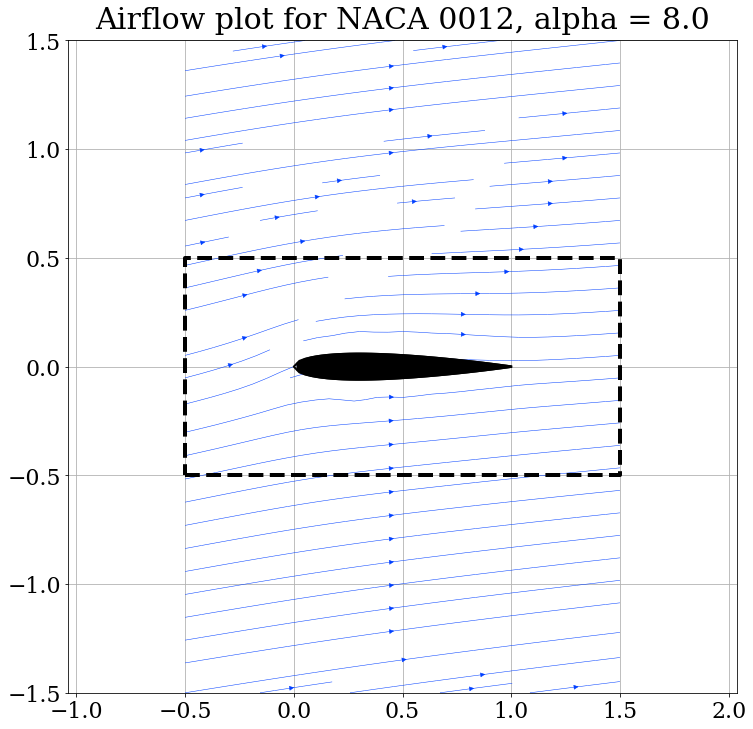

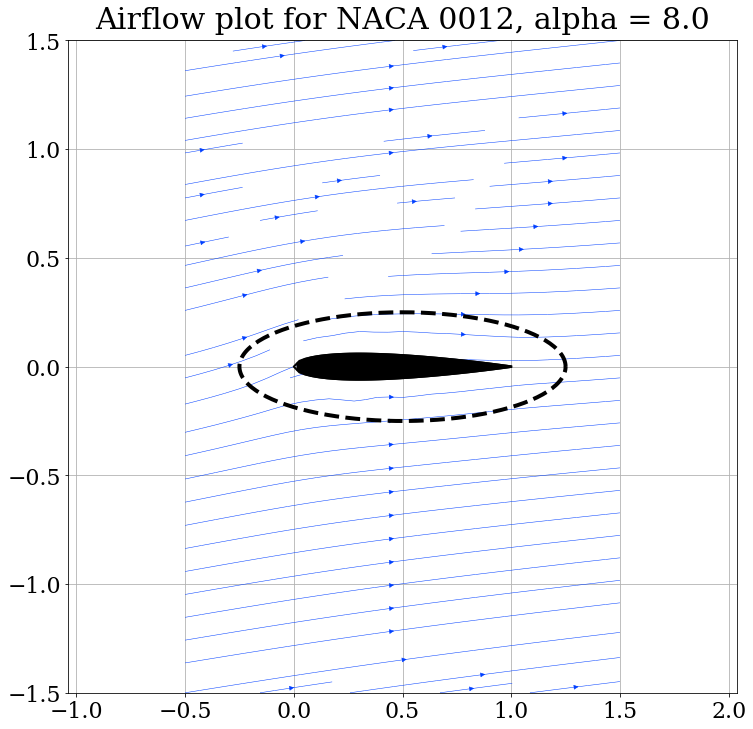

In [7]:
x_corners = [-0.5, 1.5, 1.5, -0.5]
y_corners = [-0.5, -0.5, 0.5, 0.5]

n = 50
integration_path_1_x = np.concatenate((np.linspace(x_corners[0], x_corners[1], n),
                                       np.linspace(x_corners[1], x_corners[2], n),
                                       np.linspace(x_corners[2], x_corners[3], n),
                                       np.linspace(x_corners[3], x_corners[0], n),))

integration_path_1_y = np.concatenate((np.linspace(y_corners[0], y_corners[1], n),
                                       np.linspace(y_corners[1], y_corners[2], n),
                                       np.linspace(y_corners[2], y_corners[3], n),
                                       np.linspace(y_corners[3], y_corners[0], n),))

# Circular Path 

integration_path_2_x = 0.75 * np.cos(np.linspace(0, 2 * np.pi, n*4)) + 0.5
integration_path_2_y = np.sin(np.linspace(0, 2 * np.pi, n*4)) / 4

# PLOTS 
fig, flowplot = plt.subplots()
plt.streamplot(X, Y, u, v, density=1, linewidth=0.5, cmap='coolwarm')
plt.axis('equal')
plt.plot(xdat, ydat, color='k', linewidth=2)
plt.plot(integration_path_1_x, integration_path_1_y, linewidth=4, color='k', linestyle='--')
plt.title(f"Airflow plot for {airfoilname}, alpha = {rad2deg(alpha)}")
plt.fill([panel.xc for panel in panel_list],
         [panel.yc for panel in panel_list],
         color='black',
         linestyle='-',
         linewidth=2,
         zorder=2)

fig, flowplot = plt.subplots()
plt.streamplot(X, Y, u, v, density=1, linewidth=0.5, cmap='coolwarm')
plt.axis('equal')
plt.plot(xdat, ydat, color='k', linewidth=2)
plt.plot(integration_path_2_x, integration_path_2_y, linewidth=4, color='k', linestyle='--')
plt.title(f"Airflow plot for {airfoilname}, alpha = {rad2deg(alpha)}")
plt.fill([panel.xc for panel in panel_list],
         [panel.yc for panel in panel_list],
         color='black',
         linestyle='-',
         linewidth=2,
         zorder=2)

# Calculate Circulations

Circulation = CalculateCirculation(integration_path_1_x, integration_path_1_y, panel_list, V_fs, alpha)
print(f'Circulation is {Circulation} for {n*4} items on a rectangular path')

rectangle_lift = KuttaJoukowskiLift(Circulation, rho, V_fs)

Circulation = CalculateCirculation(integration_path_2_x, integration_path_2_y, panel_list, V_fs, alpha)
print(f'Circulation is {Circulation} for {n*4} items on a circular path')

elliptical_lift = KuttaJoukowskiLift(Circulation, rho, V_fs)


# Find Cl for comparison

C_l_rectangle = rectangle_lift / (0.5 * rho * V_fs**2 * 1)
C_l_elliptical = elliptical_lift / (0.5 * rho * V_fs**2 * 1)

print(f'Lift coefficient for elliptical path is {C_l_elliptical}')
print(f'Lift coefficient for rectangular path is {C_l_rectangle}')
print('Lift coefficient from XFOIL calculation is 0.9634')

Both circulation values are almost identical, with minor difference that is more likely attributed to error caused by numerical integration than by a effect of path change, given that the two paths are significantly different in shape. The calculated C_l values are also extremely close to the calculated $C_l$ value from XFOIL, indicating that the vortex panel method, in conjunction with the Kutta-Joukowski lift theorem, is a valid way to calculate lift for scenarios in which viscous effects are negligible, such as low speed flight.


## 3 | Lift Curve 

Calculate the lift curve for a NACA 0012 airfoil using thin airfoil theory, the vortex panel method in conjunction with the Kutta-Joukowski lift theorem, and a viscous simulation using XFOIL. Plot the results and discuss.

Additionally, plot the flow streamlines for the NACA 0012 airfoil at $\alpha = 45$ and find the stagnation point. Determine if the result is realistic, and discuss.

### 3.1 | Approach 

The first part of the problem can be solved using the method found in the previous problem to calculate coefficient of lift, but applied instead to a list of $\alpha$ values. Thin airfoil theory has a constant slope, and is simply a matter of generating points. Viscous flow data can be found using XFOIL.

The latter part of the problem can be found using the same solution as programmed in **Problem 1**, but with a high resolution meshgrid, and a contour plot to show velocity. The stagnation point is found as the point with zero veloicty.

### 3.2 | Equations

Thin airfoil theory states that the rate of change of $C_l$ with respect to alpha is constant, and is expressed as:

$$\begin{equation}
    \frac{\partial C_l}{\partial \alpha} = 2\pi
\end{equation}$$

### 3.3 | Code and Results

In [ ]:
N = 26

alphalist = np.deg2rad(np.linspace(0, 25, N))

KuttaJoukowskiC_l = np.zeros(N)
ThinAirfoilC_l = 2 * np.pi * alphalist

xfoildat = pd.read_csv("AirfoilData/NACA0012Xfoildata.csv")
for i, alpha in enumerate(alphalist):
    panel_list = vpm.MakePanels(xdat, ydat, num_panels, 'constant')    

    panel_list = vpm.SolveVorticity(panel_list, missing_panel_index,
                                    V_fs, alpha)
    Gamma = CalculateCirculation(integration_path_2_x, integration_path_2_y, 
                                 panel_list, V_fs, alpha)
    elliptical_lift = KuttaJoukowskiLift(Gamma, rho, V_fs)
    KuttaJoukowskiC_l[i] = elliptical_lift / (0.5 * rho * V_fs**2 * 1)

fig, lift_comparison = plt.subplots()
plothusly(lift_comparison,
          np.rad2deg(alphalist),
          KuttaJoukowskiC_l,
          title=fr'$C_l$ Comparison for varying mathods for {airfoilname}',
          xtitle=fr'$\alpha$',
          ytitle=fr'$C_l$',
          datalabel="Vortex panel / Kutta-Joukowski Theorem", 
          marker='x')
plothus(lift_comparison,
        np.rad2deg(alphalist),
        ThinAirfoilC_l,
        datalabel='Thin Airfoil Theory',
        marker='p')
plothus(lift_comparison,
        xfoildat["Alpha"],
        xfoildat["C_l"],
        datalabel='Viscous Xfoil, Re = 5E6')

Note that the thin airfoil theory is closer to the viscous flow simulation as calculated by XFOIL than the vortex panel method. Both the vortex panel method and the thin airfoil theory follow constant slopes beginnning at the origin. The viscous model does not, and the difference between it and the non-inviscid flow models is the viscid fluid forces. The large difference at high $\alpha$ values is caused by boundary layer seperation, in which the fluid begins to recirculate about the airfoil as caused by the adverse pressure gradient. Because of this large difference, it can be determined that the vortex panel method is not accurate for calculation of lift in scenarios in which viscous effects are non-negligible, such as in turbulent flow regimes or at high angles of attack $\alpha$.

In [ ]:
alpha = np.deg2rad(45)

panel_list = vpm.MakePanels(xdat, ydat, num_panels, 'constant')    
panel_list = vpm.SolveVorticity(panel_list, missing_panel_index,
                                    V_fs, alpha)

x = np.linspace(-0.5, 1.5, 200)
y = np.linspace(-1.5, 1.5, 200)
X, Y = np.meshgrid(x, y)
u, v = vpm.GetVelocity(X, Y, panel_list, V_fs, alpha)
V = (u**2 + v**2)**0.5
fig, flowplot = plt.subplots()
plt.streamplot(X, Y, u, v, density=5, linewidth=0.5)
plt.contourf(X, Y, V, cmap='viridis', alpha=0.5, levels=np.linspace(0, 3, 10))
cbar = plt.colorbar()
cbar.set_label("Fluid Velocity (m/s)")
plt.axis('equal')
plt.plot(xdat, ydat, color='k', linewidth=2)
plt.title(f"Airflow plot for {airfoilname}, alpha = {rad2deg(alpha)}")
plt.fill([panel.xc for panel in panel_list],
         [panel.yc for panel in panel_list],
         color='black',
         linestyle='-',
         linewidth=2,
         zorder=2)

The stagnation point can be found as the point at which the velocity is zero.

Note that the stagnation point seems to occur on the underside of the airfoil, at approximately $\frac{x}{c} = 0.45$. While this is a somewhat logical place for the stagnation point to occur, it is accompanied by an extremely high velocity at the leading edge of the airfoil. This speed would be significantly reduced in a viscid flow model. In addition, the flow on the upper surface of the airfoil would be accompanied by significant boundary layer seperation in a viscid flow model, as the result of the high angle of attack. 

## 4 | Additional Problems

### 4.1 | Lifting Rotating Cylinder

Consider an aircraft with the properties of a Cessna 172, but with the wings replaced with rotating cylinders. Plot the required rotation speed $\Omega$ against rotor size $R$. Assume a standard atmosphere, at sea level.

#### 4.1.1 | Approach

Given equilibrium flight conditions, and freestream conditions, required rotor rotation speed $\Omega$ is a function of rotor radius $R$. From total lift $L$, $\Gamma$ can be solved for. As $\Gamma$ is a function of $R$ and $\Omega$, solving for $\Omega$ will yield $\Omega$ as a function of $R$, which can then be plotted.

#### 4.1.2 | Equations

Sectional lift $L^{'}$, or lift per unit length, is given as:

$$\begin{equation}
    L^{'} = \rho_\infty V_\infty \Gamma
\end{equation}$$

Total lift is therefore:

$$\begin{equation}
    L = \rho_\infty V_\infty \Gamma b
\end{equation}$$

where $b$ is the length of the rotor.

Circulation $\Gamma$ is found as:

$$\begin{equation}
    \Gamma = (2\pi R)^2 \Omega
\end{equation}$$

Solving for $\Omega$:

$$\begin{equation}
    \Omega = \frac{\Gamma}{(2\pi R)^2}
\end{equation}$$



#### 4.1.3 | Code and Results

In [ ]:
# 4.1

mph2fps = lambda v: v * 1.46667

W = 1669  # lbf
b = 36  # ft
rho = 0.00237717  # slug/ft**3
V = mph2fps(140)  # ft/s


Gamma = W / (rho * V * b)

R = np.linspace(1, 20, 2001)
Omega = Gamma / (2 * np.pi * R)**2

fig, omegaplot = plt.subplots()

plothusly(omegaplot,
          R,
          Omega,
          xtitle=r"Rotor Radius $R$ (ft)",
          ytitle=r'Rotor speed $\Omega$',
          title="Rotorcraft Speed Requirements",
          datalabel="Cessna 172R")

### 4.2 | Airfoil Performance

Calculate lift and drag forces for the NACA 2412, 4412, and 23012 airfoils, each of which has a 12% maximum thickness. Use an $\alpha$ value of 5, and Reynold's numbers of $5E6, 9E6$. Assume a 7 foot chord length, and a constant $\mu$. 

#### 4.2.1 | Approach

Lift and drag coefficients can be found using XFOIL. Most freestream conditions can be found as part of the standard atmosphere tables, but the velocity for each condition must be found from the Reynold's number. Once all necessary components have been found, 

#### 4.2.2 | Equations

Reynold's number is found as:

$$\begin{equation}
    Re = \frac{\rho V c}{\mu}
\end{equation}$$

Solving for velocity:

$$\begin{equation}
    V = \frac{Re \mu}{\rho c}
\end{equation}$$

Sectional lift for each airfoil can be found as:


$$\begin{equation}
    L^{'} = \frac{1}{2} \rho C_L c (\frac{Re \mu}{\rho c})^2
\end{equation}$$

Similarly, sectional drag can be found as:

$$\begin{equation}
    D^{'} = \frac{1}{2} \rho C_D c (\frac{Re \mu}{\rho c})^2
\end{equation}$$

#### 4.2.3 | Code and Results

In [ ]:
prob42dat = pd.read_csv("AirfoilData/VariedNACAdat.csv")

# Standard Atmosphere Properties

column_names = ["Reynold's",
                "NACA 2412 Lift", "NACA 2412 Drag", 
                "NACA 4412 Lift", "NACA 4412 Drag",
                "NACA 23012 Lift", "NACA 23012 Drag"]

Liftdat = pd.DataFrame(columns=column_names)

rho = 0


Re = 9E6 
chord = 7 # ft
rho = 20.48E-4 # slug/ft**3

mu = 3.637E-7 # slug  / (ft-s) FROM ENGINEERING TOOLBOX


# Formula for v_inf
# v_inf = Re * mu / (rho * chord)


const2force = lambda C, Re: (0.5 * rho * C * chord * (Re * mu / (rho * chord))**2)

Liftdat["Reynold's"] = prob42dat["Reynolds"]

Liftdat["NACA 2412 Lift"] = const2force(prob42dat["NACA 2412 C_l"],
                                        prob42dat["Reynolds"])

Liftdat["NACA 2412 Drag"] = const2force(prob42dat["NACA 2412 C_d"],
                                        prob42dat["Reynolds"])

Liftdat["NACA 4412 Lift"] = const2force(prob42dat["NACA 4412 C_l"],
                                        prob42dat["Reynolds"])

Liftdat["NACA 4412 Drag"] = const2force(prob42dat["NACA 4412 C_d"],
                                        prob42dat["Reynolds"])

Liftdat["NACA 23012 Lift"] = const2force(prob42dat["NACA 23012 C_l"],
                                        prob42dat["Reynolds"])

Liftdat["NACA 23012 Drag"] = const2force(prob42dat["NACA 23012 C_d"],
                                        prob42dat["Reynolds"])

# print(Liftdat)

|    |   NACA 2412 Lift |   NACA 2412 Drag |   NACA 4412 Lift |   NACA 4412 Drag |   NACA 23012 Lift |   NACA 23012 Drag |
|---:|-----------------:|-----------------:|-----------------:|-----------------:|------------------:|------------------:|
|  0 |          46.0637 lbf |         0.415628 lbf |          54.7957 lbf |         0.446769 lbf|           43.9337 lbf |          0.336323 lbf|
|  1 |         421.076 lbf |         3.10538  lbf|         501.233  lbf|         3.47907 lbf |          384.791  lbf|          2.4701   lbf|

Note that the 23012 has the lowest drag force of all airfoils tested here. This is likely due to the 23012's "drag bucket", caused by the significant laminar flow over a significant part of the airfoil. It does, however, produce significantly less lift force than the 2412 or the 4412. The 4412 produces the most lift, due to its higher camber, but produces more drag for the same reasons. The 2412 produces less drag than the 4412, although not much to justify its choice over the 4412 at low speeds.

### 4.3 | Airfoil Efficiency

For the same 3 airfoils, plot the $L/D$ ratio as a function of angle of attack. Use a Reynold's number of $9E6$. Estimate the maximum $L/D$ value for each.

#### 4.3.1 | Approach

$C_l$ and $C_d$ values can be generated for a range of $\alpha$ values for each airfoil, which can then be used to determine $\frac{L}{D}$. The angle of attack at which maximum $\frac{L}{D}$ occurs can then be determined graphically.

#### 4.3.2 | Equations

Lift to drag ratio is determined as:

$$\begin{equation}
    \frac{L}{D} = \frac{C_l}{C_d}
\end{equation}$$

#### 4.3.3 | Code and Results

In [ ]:
# 4.3 

airfoildatabase = pd.DataFrame()

alphalist = np.linspace(0, 25, 26)

# pyx.GetPolar(foil='2412', naca=True, alfs=alphalist, Re=9E6)
naca2412 = pyx.ReadXfoilPolar("Data/naca2412/naca2412_polar_Re9.00e+06a0.0-25.0.dat")

# pyx.GetPolar(foil='4412', naca=True, alfs=alphalist, Re=9E6)
naca4412 = pyx.ReadXfoilPolar("Data/naca4412/naca4412_polar_Re9.00e+06a0.0-25.0.dat")

# pyx.GetPolar(foil='23012', naca=True, alfs=alphalist, Re=9E6)
naca23012 = pyx.ReadXfoilPolar("Data/naca23012/naca23012_polar_Re9.00e+06a0.0-25.0.dat")

findLD = lambda df: (df["Cl"] / df["Cd"])

naca2412["L/D"] = findLD(naca2412)
naca4412["L/D"] = findLD(naca4412)
naca23012["L/D"] = findLD(naca23012)

fig, LDplot = plt.subplots()

plothusly(LDplot, 
          naca2412["alpha"],
          naca2412["L/D"],
          title="L/D Ratio comparison for Multiple Airfoils",
          xtitle=r"$\alpha$",
          ytitle=r"$\frac{L}{D}$",
          datalabel="NACA 2412",
          marker='p')

plothus(LDplot,
        naca4412["alpha"],
        naca4412["L/D"],
        datalabel="NACA 4412",
        marker='o')

plothus(LDplot,
        naca23012["alpha"],
        naca23012["L/D"],
        datalabel="NACA 23012",
        marker='d')


**Please note:** Significant issues were encountered while running pyxfoil due to conflicts with the Linux-based operating system. The code cell was transferred to Windows, and was run, generating the files available in the directory. The code that called the actual execution of XFOIL by pyxfoil was commented out, and the file was transferred back to the Linux OS.

The 4412 has the highest peak $L/D$ ratio of all the airfoils tested, at approximately 170, and occurs at $\alpha = 5$ degrees. However, at increasing angles of attack, it has a significantly lower $L/D$ ratio as compared to the other airfoils, likely caused by an earlier stall due to its higher camber. The interesting point of this graph lies in comparison between the 2412 and the 23012. Both have their maximum $L/D$ ratio at the same point ($\alpha = 8$), but the 23012's is much higher, at $\approx 155$, compared to the 2412's $\approx 130$. This is due to the drag bucket on the 23012, caused by significant laminar flow, which in turn is caused by the farther aft position of the maximum thickness on the 23012. 

### 4.4 | Induced Drag

For an airplane with a weight of 9000 N, wing area $S = 18.3 m^2$, aspect ratio $(AR) = 9$, and a span efficiency factor $e=0.75$, find the induced drag force of the aircraft. Consider both cruise ($V = 245 km/hr$, Alt. $= 32,000 ft$), and landing ($V = 85km/hr$, Alt. $ = 0 ft$). Use standard atmosphere tables to determine freestream properties.

#### 4.4.1 | Approach

Induced drag is found through the coefficient of lift $C_L$. Given that the aircraft is in equilibirium flight and all other conditions are known, $C_L$ can be calculated from the lift and freestream properties, and the induced drag $C_D$ can be found from $C_L$. The drag force of the aircraft can then be found from the calculated drag coefficient $C_D$ and freestream properties. 

#### 4.4.2 | Equations

Rearranging the lift equation for a 3D airfoil, coefficient of lift $C_L$ can be expressed as:

$$\begin{equation}
    C_L = \frac{W}{\frac{1}{2} \rho V^2 S}
\end{equation}$$

Induced drag $C_{D_{ind}}$ can be found in terms of $C_L$:

$$\begin{equation}
    C_{D_{ind}} = \frac{C_L^2}{\pi e (AR)} 
\end{equation}$$

Finally, induced drag can be found using freestream properties and $C_{D_{ind}}$

$$\begin{equation}
    D = \frac{1}{2} \rho V_\infty C_{D_{ind}} S
\end{equation}$$


#### 4.4.3 | Code and Results


In [ ]:
# 4.4 

kmhr2mps = lambda v: v * 0.277778
slugft3_2_kgm3 = lambda slug: slug * 515.379


e = 0.75
AR = 9
S = 18.3  # m/s**20.277778
W = 9E3  # N

Clfind = lambda V, rho: W / (0.5 * rho * V**2 * S)
Cdindfind = lambda Cl: Cl**2 / (np.pi * e * AR)
Dfind = lambda Cd, V, rho: 0.5 * rho * V**2 * S * Cd



# Cruise

V = kmhr2mps(245)  # m/s
rho = slugft3_2_kgm3(0.000825628)  # kg/m**3



cruiseCL = Clfind(V, rho)
cruiseCD = Cdindfind(cruiseCL)
cruiseD = Dfind(cruiseCD, V, rho)

# Landing

V = kmhr2mps(85)  # m/s
rho = 1.22500  # m/s

landCL = Clfind(V, rho)
landCD = Cdindfind(landCL)
landD = Dfind(landCD, V, rho)


column_names = ["Cruise Drag Force (N)"]
df = pd.DataFrame(np.array([cruiseD]), columns = column_names)

df["Landing Drag Force (N)"] = landD

|    |   Cruise Drag Force (N) |   Landing Drag Force (N) |
|---:|------------------------:|-------------------------:|
|  0 |                 211.822 |                  611.281 |


### 4.5 | Airfoil Selection

**What is your favourite airfoil, and why?**

My favorite airfoil is the NACA 2412 (Shown below)

In [ ]:
x, y = NACAThicknessEquationMOD(2, 4, 12, 100)

fig, geoplot = plt.subplots()

plothusly(geoplot, x, y,
          xtitle=r"$\frac{x}{c}$",
          ytitle=r'$\frac{z}{c}$',
          title="NACA 2412 Geometry",
          datalabel="NACA 2412")
plt.fill(x, y,)
plt.axis('equal')

I used to run the Aerobrick team which, last year, was the only aircraft design club on campus. As a part of that club, I had the opportunity to design a heavy lift aircraft for a competition against international teams. Our team's previous entry had been a fairly high drag design, and the switch to a NACA 2412 airfoil allowed us to keep a relatively high lift while significantly reducing drag.

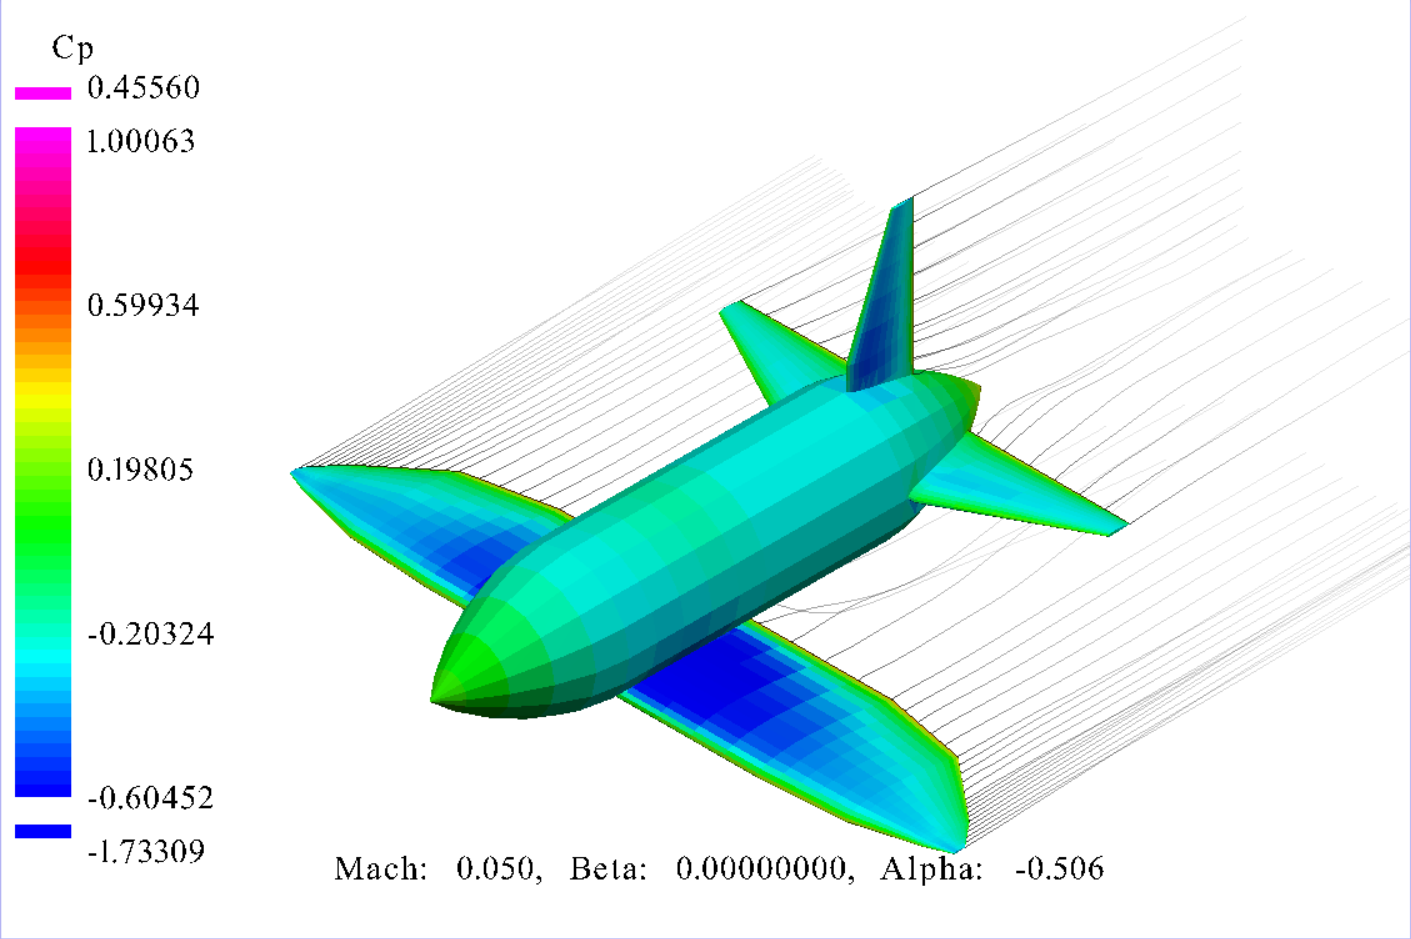

There is nothing particurly remarkable about this airfoil. There are certainly better airfoils, and had I a better idea of how to design aircraft, even knowing what I know now, I would have made a different choice of airfoil (likely a NACA 23012). But I didn't, and so the 2412 is my favourite airfoil because it was used on the first plane I designed.

## 5 | Conclusion

The vortex panel method is an accurate way to calculate lift for low speeds, but encounters issues for turbulent flow. The results for inviscid flow were accurate compared to the XFOIL results, and as such, the vortex panel method can be considered to be an accurate method for lift calculation at low values of $V_\infty$. Note, however, the results from **Problem 3**: Although the vortex panel method, in conjunction with the Kutta-Joukowski theorem, produced a _similar_ lift coefficient $C_l$, it was not as accurate as the thin airfoil theorem, and failed to model flow seperation. This is because the vortex panel method is based on potential flow theory, which is unable to model viscous effects. In this way, vortex panel method cannot be considered to be accurate for turbulent flow, or at high angles of attack.